In [6]:
!pip install yfinance pandas numpy scikit-learn tensorflow joblib matplotlib streamlit

  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5


[*********************100%***********************]  1 of 1 completed


Data shape after download: (8308, 2)

===== Tail Risk Summary =====
Horizon        : 10 days
Threshold      : -5.0%
Total samples  : 8298
Tail events    : 389
Event rate     : 4.688%

Last available date: 2026-01-30 00:00:00
Train feature columns:
['Close', 'Volume', 'forward_return', 'tail_event', 'log_return_1d', 'vol_10', 'vol_20', 'vol_60', 'drawdown_20', 'mom_10', 'mom_50', 'volume_ratio_20']
Live inference date: 2026-01-30 00:00:00
Shapes:
X_train: (5766, 8) y_train: (5766,)
X_val  : (1236, 8) y_val  : (1236,)
X_test : (1236, 8) y_test : (1236,)

Tail event rate:
Train: 0.04769337495664239
Val  : 0.042071197411003236
Test : 0.05016181229773463
Train tail events: 275
Val tail events  : 52
Test tail events : 62
Class weights: {0: 0.5250409761427791, 1: 10.483636363636364}


C:\Users\manan\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.6499 - precision: 0.0663 - recall: 0.8256 - val_loss: 0.5376 - val_precision: 0.0824 - val_recall: 0.4038
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5992 - precision: 0.1167 - recall: 0.7370 - val_loss: 0.5028 - val_precision: 0.0744 - val_recall: 0.3462
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5252 - precision: 0.1203 - recall: 0.7773 - val_loss: 0.5056 - val_precision: 0.0824 - val_recall: 0.4231
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5556 - precision: 0.1130 - recall: 0.7284 - val_loss: 0.4777 - val_precision: 0.0741 - val_recall: 0.3462
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5876 - precision: 0.1243 - recall: 0.7363 - val_loss: 0.4507 - val_precision: 0.0783 - val_recall: 0.3462
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5633 - precision: 0.1243 - recall: 0.7200 - val_loss: 0.4940 - val_precision: 0.0758 - val_recall:

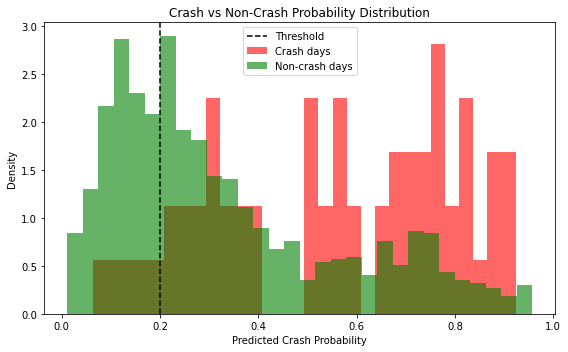

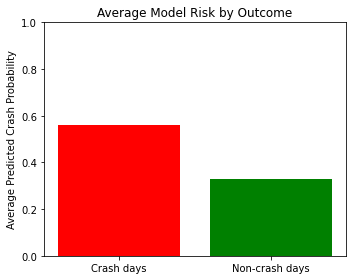

C:\Users\manan\AppData\Local\Temp/ipykernel_33964/3920779.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_crash_rate = df_crash_rate.groupby("risk_bucket")["crash"].mean()


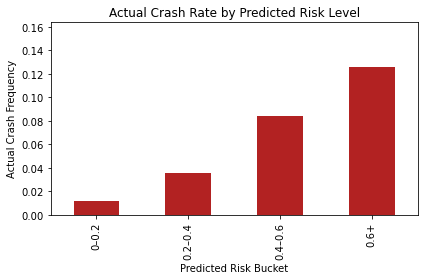

C:\Users\manan\AppData\Local\Temp/ipykernel_33964/3920779.py:431: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tail


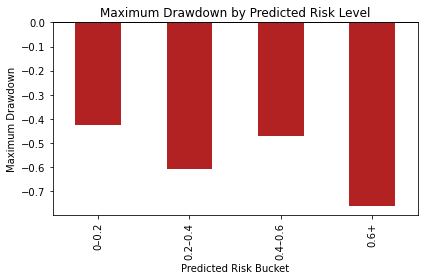

In [13]:
# ===============================
# Tail Risk Data Preparation
# ===============================

import yfinance as yf
import pandas as pd

# -------------------------------
# Parameters (LOCKED FOR NOW)
# -------------------------------
START_DATE = "1990-01-01"
HORIZON = 10        # days ahead
THRESHOLD = -0.05  # -5% loss

# -------------------------------
# Step 1: Download Index Data
# -------------------------------
print("Downloading data...")

df = yf.download("SPY", start=START_DATE, auto_adjust=False)
df.columns = df.columns.get_level_values(0)

# Keep only what we need
df = df[['Close', 'Volume']]
df.dropna(inplace=True)

print(f"Data shape after download: {df.shape}")

# -------------------------------
# Step 2: Split into TRAIN and LIVE
# -------------------------------
df_train = df.iloc[:-HORIZON].copy()   # labels allowed
df_live  = df.copy()                   # inference only

# -------------------------------
# Step 3: Create Forward Returns (TRAIN ONLY)
# -------------------------------
df_train['forward_return'] = (
    df_train['Close'].shift(-HORIZON) / df_train['Close'] - 1
)

# -------------------------------
# Step 4: Create Tail Risk Label (TRAIN ONLY)
# -------------------------------
df_train['tail_event'] = (df_train['forward_return'] <= THRESHOLD).astype(int)

# -------------------------------
# Step 5: Sanity Checks
# -------------------------------
positive_rate = df_train['tail_event'].mean()
num_events = df_train['tail_event'].sum()
total = len(df_train)

print("\n===== Tail Risk Summary =====")
print(f"Horizon        : {HORIZON} days")
print(f"Threshold      : {THRESHOLD * 100:.1f}%")
print(f"Total samples  : {total}")
print(f"Tail events    : {num_events}")
print(f"Event rate     : {positive_rate:.3%}")
print("=============================\n")

print("Last available date:", df.index.max())

#--------------------------------------------------------------------------------------
import numpy as np

def add_features(df):
    df = df.copy()

    df['log_return_1d'] = np.log(df['Close'] / df['Close'].shift(1))

    df['vol_10'] = df['log_return_1d'].rolling(10).std()
    df['vol_20'] = df['log_return_1d'].rolling(20).std()
    df['vol_60'] = df['log_return_1d'].rolling(60).std()

    rolling_max_20 = df['Close'].rolling(20).max()
    df['drawdown_20'] = df['Close'] / rolling_max_20 - 1

    df['mom_10'] = df['Close'] / df['Close'].shift(10) - 1
    df['mom_50'] = df['Close'] / df['Close'].shift(50) - 1

    vol_mean_20 = df['Volume'].rolling(20).mean()
    df['volume_ratio_20'] = df['Volume'] / vol_mean_20

    return df


# Apply features separately
df_train = add_features(df_train)
df_live  = add_features(df_live)

feature_cols = [
    'log_return_1d',
    'vol_10', 'vol_20', 'vol_60',
    'drawdown_20',
    'mom_10', 'mom_50',
    'volume_ratio_20'
]

# Drop NaNs ONLY for training
df_train = df_train.dropna(subset=feature_cols)

print("Train feature columns:")
print(df_train.columns.tolist())

# IMPORTANT: keep Date as a column
df_train.reset_index().to_csv("tail_risk_train_data.csv", index=False)
df_live.reset_index().to_csv("tail_risk_live_data.csv", index=False)


print("Live inference date:", df_live.index.max())

#---------------------------------------------------------------------------------
import numpy as np
from sklearn.preprocessing import StandardScaler

# -------------------------
# Create X (features) and y (labels) — TRAIN ONLY
# -------------------------
X = df_train[feature_cols].values
y = df_train['tail_event'].values

# -------------------------
# Time-based split (NO SHUFFLING)
# -------------------------
n = len(df_train)

train_end = int(0.70 * n)
val_end   = int(0.85 * n)

X_train = X[:train_end]
y_train = y[:train_end]

X_val = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test = X[val_end:]
y_test = y[val_end:]

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape, "y_val  :", y_val.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)

# -------------------------
# Sanity check: tail event rate
# -------------------------
print("\nTail event rate:")
print("Train:", y_train.mean())
print("Val  :", y_val.mean())
print("Test :", y_test.mean())

# -------------------------
# Feature scaling (FIT ON TRAIN ONLY)
# -------------------------
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# -------------------------
# Prepare LIVE inference input (today)
# -------------------------
X_today = df_live[feature_cols].iloc[-1].values.reshape(1, -1)
X_today_scaled = scaler.transform(X_today)

print("Train tail events:", y_train.sum())
print("Val tail events  :", y_val.sum())
print("Test tail events :", y_test.sum())

#-----------------------------------------------------------------------------------------------------
# ===============================
# STEP 5: NEURAL NETWORK TRAINING
# ===============================

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils.class_weight import compute_class_weight

# -------------------------------
# 0. Compute class weights (TRAIN ONLY)
# -------------------------------
classes = np.array([0, 1])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

print("Class weights:", class_weight_dict)

# -------------------------------
# 1. Build the neural network
# -------------------------------
model = Sequential([
    Dense(32, activation='relu',
          input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# -------------------------------
# 2. Compile the model
# -------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision")
    ]
)

# -------------------------------
# 3. Train (TRAIN + VALIDATION ONLY)
# -------------------------------
history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,   # ✅ added
    verbose=1
)

# -------------------------------
# 4. Validation probabilities (for analysis / thresholding)
# -------------------------------
y_val_proba = model.predict(X_val_scaled)

# -------------------------------
# 5. FINAL TEST EVALUATION (ONCE)
# -------------------------------
test_loss, test_recall, test_precision = model.evaluate(
    X_test_scaled,
    y_test,
    verbose=1
)

print(f"\nFinal Test Recall   : {test_recall:.3f}")
print(f"Final Test Precision: {test_precision:.3f}")

# -------------------------------
# 6. Test probabilities (analysis only)
# -------------------------------
y_test_proba = model.predict(X_test_scaled)

print("Test probability stats:")
print("Min :", y_test_proba.min())
print("Max :", y_test_proba.max())
print("Mean:", y_test_proba.mean())

# -------------------------------
# 7. ✅ TODAY’S RISK (LIVE INFERENCE)
# -------------------------------
today_risk = model.predict(X_today_scaled)[0, 0]
print(f"Tail risk over next {HORIZON} days (as of today): {today_risk:.3f}")

#-----------------------------------------------------------------------------------------------------------------------
import numpy as np
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score,
    brier_score_loss
)

# Decision threshold
THRESHOLD =0.20 

print("Using fixed threshold:", THRESHOLD)
y_test_pred = (y_test_proba >= THRESHOLD).astype(int)

# ---- Metrics ----
precision = precision_score(y_test, y_test_pred, zero_division=0)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)
brier = brier_score_loss(y_test, y_test_proba)

# ---- Print results ----
print("Evaluation Metrics")
print("------------------")
print(f"Precision   : {precision:.4f}")
print(f"Recall      : {recall:.4f}")
print(f"ROC-AUC     : {roc_auc:.4f}")
print(f"Brier Score : {brier:.4f}")

#-------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))

plt.hist(
    y_test_proba[y_test == 1],
    bins=30,
    alpha=0.6,
    label="Crash days",
    color="red",
    density=True
)

plt.hist(
    y_test_proba[y_test == 0],
    bins=30,
    alpha=0.6,
    label="Non-crash days",
    color="green",
    density=True
)

plt.axvline(THRESHOLD, color="black", linestyle="--", label="Threshold")

plt.xlabel("Predicted Crash Probability")
plt.ylabel("Density")
plt.title("Crash vs Non-Crash Probability Distribution")
plt.legend()
plt.tight_layout()
plt.show()

#-------------------------------------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

avg_crash = y_test_proba[y_test == 1].mean()
avg_noncrash = y_test_proba[y_test == 0].mean()

plt.figure(figsize=(5,4))
plt.bar(
    ["Crash days", "Non-crash days"],
    [avg_crash, avg_noncrash],
    color=["red", "green"]
)

plt.ylabel("Average Predicted Crash Probability")
plt.title("Average Model Risk by Outcome")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#-----------------------------------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

y_test_proba = y_test_proba.ravel()

# Create dataframe
df_crash_rate = pd.DataFrame({
    "prob": y_test_proba,
    "crash": y_test
})

# Risk buckets
bins = [0, 0.2, 0.4, 0.6, 1.0]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6+"]

df_crash_rate["risk_bucket"] = pd.cut(df_crash_rate["prob"], bins=bins, labels=labels)

# Compute actual crash rate per bucket
bucket_crash_rate = df_crash_rate.groupby("risk_bucket")["crash"].mean()

# Plot
bucket_crash_rate.plot(
    kind="bar",
    color="firebrick",
    figsize=(6,4)
)

plt.ylabel("Actual Crash Frequency")
plt.xlabel("Predicted Risk Bucket")
plt.title("Actual Crash Rate by Predicted Risk Level")
plt.ylim(0, bucket_crash_rate.max() * 1.3)
plt.tight_layout()
plt.show()

#-------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1. Ensure predictions are 1D
# -------------------------------
y_test_proba = np.asarray(y_test_proba).ravel()
n_test = len(y_test_proba)

# -------------------------------
# 2. Align test rows (CORRECT SOURCE)
# -------------------------------
# Recreate the SAME test split used in training
n = len(df_train)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

df_tail = df_train.iloc[val_end:].copy()
assert len(df_tail) == n_test, "Mismatch between test data and predictions"

df_tail["prob"] = y_test_proba

# -------------------------------
# 3. Risk buckets
# -------------------------------
bins = [0.0, 0.2, 0.4, 0.6, 1.0]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6+"]

df_tail["risk_bucket"] = pd.cut(
    df_tail["prob"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# -------------------------------
# 4. Compute max drawdown per bucket
# -------------------------------
def max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

bucket_drawdowns = (
    df_tail
    .groupby("risk_bucket")["forward_return"]
    .apply(max_drawdown)
)

# -------------------------------
# 5. Plot
# -------------------------------
bucket_drawdowns.plot(
    kind="bar",
    figsize=(6,4),
    color="firebrick"
)

plt.ylabel("Maximum Drawdown")
plt.xlabel("Predicted Risk Bucket")
plt.title("Maximum Drawdown by Predicted Risk Level")
plt.axhline(0, color="black", linewidth=1)

plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------------
# Save model
model.save("tail_risk_model.keras")

# Save scaler (if used)
import joblib
joblib.dump(scaler, "scaler.pkl")
feature_cols = [
    'log_return_1d',
    'vol_10', 'vol_20', 'vol_60',
    'drawdown_20',
    'mom_10', 'mom_50',
    'volume_ratio_20'
]
joblib.dump(feature_cols, "features.pkl")
# Save processed dataframe (must include forward_return)
df.to_csv("processed_data.csv", index=False)